# Map 3 - Unconformity

This map is from Bennison et al. (2011). Like map 2, this map also has an unconformity. First, we import the required libraries:

In [1]:
# Import libraries
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import geopandas as gpd
import rasterio
import gempy as gp
import gemgis as gg
from pyvistaqt import BackgroundPlotter

Then, we display the map image:

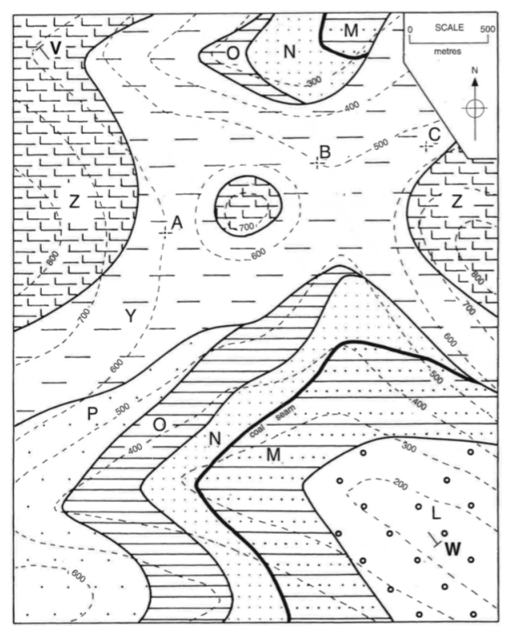

In [2]:
# Display map image
img = mpimg.imread("map3.png")
fig, ax = plt.subplots(1, figsize=(8,8))
ax.imshow(img)
ax.axis("off");

## 1. Topography

### Read and plot the contours

In [3]:
def df_to_gdf(path, sep):
    """
    Make pandas DataFrame from path to text file
    and convert it to and return geopandas DataFrame
    sep is the separator of the columns in the text file
    """
    df = pd.read_csv(path, sep=sep)
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X, df.Y), crs="EPSG:4326") # use WGS84 projection
    return gdf

In [4]:
# Read the topographic contours
topo = df_to_gdf(os.path.join("contours", "contours.txt"), sep="\t")
topo.head()

,X,Y,Z,geometry
0,3069.86,94.40,200,POINT (3069.85800 94.40000)
1,3023.48,125.53,200,POINT (3023.48200 125.52700)
2,3000.74,148.50,200,POINT (3000.74500 148.49600)
3,2972.87,174.05,200,POINT (2972.87400 174.04600)
4,2934.09,201.61,200,POINT (2934.09500 201.61200)


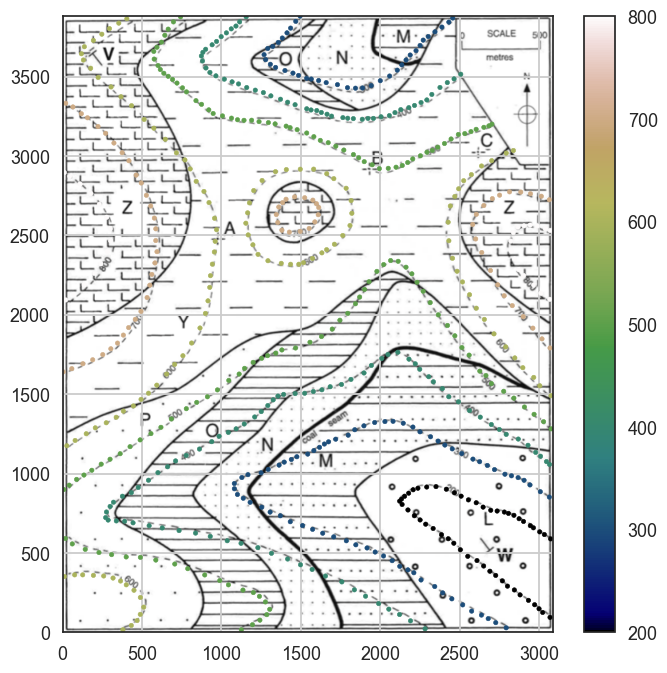

In [5]:
# Plot the contours
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(img, extent=[0, 3090, 0, 3880], cmap="gray")
topo.plot(ax=ax, aspect="equal",column="Z", cmap="gist_earth", legend=True, markersize=10)
ax.set_ylim((0,3880))
ax.set_xlim((0,3090))
ax.grid();

### Interpolate the contour lines to make a digital elevation model (DEM)

In [6]:
# Interpolate contour lines to make DEM
topo_raster = gg.vector.interpolate_raster(gdf=topo,value="Z",method="rbf",res=5)

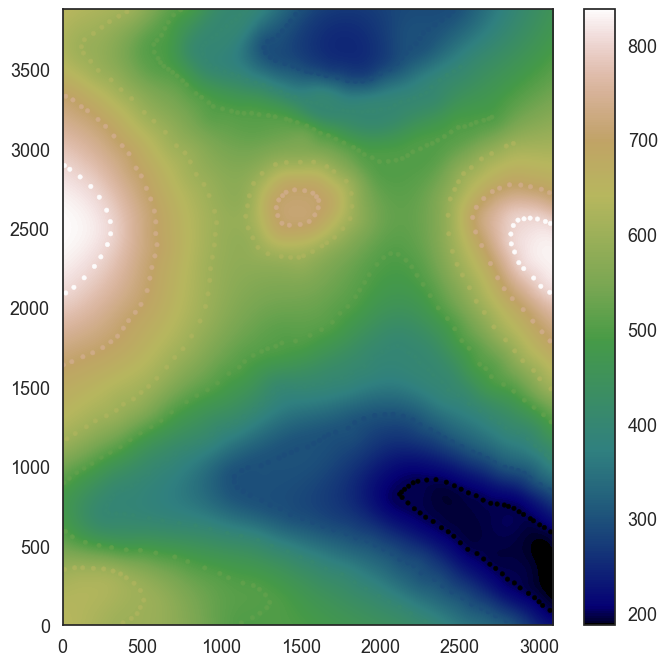

In [7]:
# Plot the DEM
fig, ax = plt.subplots(1, figsize=(8, 8))
topo.plot(ax=ax, aspect="equal", column="Z", cmap="gist_earth", markersize=10)
im = ax.imshow(topo_raster, origin="lower", extent=[0, 3090, 0, 3880], cmap="gist_earth")
cbar = plt.colorbar(im);

In [8]:
# Save the DEM as a tif file
gg.raster.save_as_tiff(raster=topo_raster, path="dem_map3.tif", 
                       extent=[0, 3090, 0, 3880], crs="EPSG:4326", overwrite_file=True)

Raster successfully saved


In [9]:
# Open the DEM from tif file
topo_raster = rasterio.open("dem_map3.tif")

## 2. Stratigraphic boundaries or units' contacts

In [10]:
# Read the contacts. These are the bases of the units
contacts = df_to_gdf(os.path.join("contacts", "contacts.txt"), sep="\t")
contacts.head()

,X,Y,formation,geometry
0,868.46,156.18,P,POINT (868.46000 156.18400)
1,478.23,985.51,P,POINT (478.22700 985.50700)
2,1100.96,1584.28,P,POINT (1100.96300 1584.27700)
3,1347.14,301.74,O,POINT (1347.13800 301.74000)
4,998.15,1070.69,O,POINT (998.14800 1070.69300)


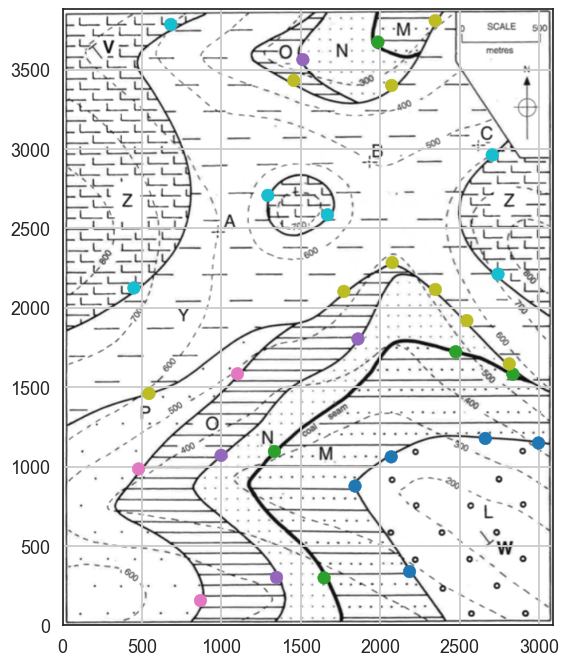

In [11]:
# Plot the points on the contacts
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(img, extent=[0, 3090, 0, 3880], cmap="gray")
contacts.plot(ax=ax, column="formation", aspect="equal")
ax.set_ylim((0,3880))
ax.set_xlim((0,3090))
ax.grid();

### Extracting Z coordinate

In [12]:
# Extract the Z coordinate of the points at the contacts
contacts_with_Z = gg.vector.extract_xyz(gdf=contacts, dem=topo_raster)
contacts_with_Z.head()

,X,Y,formation,geometry,Z
0,868.46,156.18,P,POINT (868.46000 156.18400),537.22
1,478.23,985.51,P,POINT (478.22700 985.50700),418.81
2,1100.96,1584.28,P,POINT (1100.96300 1584.27700),495.28
3,1347.14,301.74,O,POINT (1347.13800 301.74000),468.92
4,998.15,1070.69,O,POINT (998.14800 1070.69300),344.60


### Strike lines

In [13]:
# Read the strike lines at the base of N, P and Y
gdf_N = df_to_gdf(os.path.join("strike_lines", "strike_lines_N.txt"), sep="\t")
gdf_P = df_to_gdf(os.path.join("strike_lines", "strike_lines_P.txt"), sep="\t")
gdf_Y = df_to_gdf(os.path.join("strike_lines", "strike_lines_Y.txt"), sep="\t")

In [14]:
# Convert the points into strike lines
linestring_gdf_N = gg.vector.create_linestring_gdf(gdf=gdf_N)
linestring_gdf_P = gg.vector.create_linestring_gdf(gdf=gdf_P)
linestring_gdf_Y = gg.vector.create_linestring_gdf(gdf=gdf_Y)

In [15]:
# Check that the strike lines are valid
print("N\n", linestring_gdf_N.is_valid)
print("P\n", linestring_gdf_P.is_valid)
print("Y\n", linestring_gdf_Y.is_valid)

N
 0    True
1    True
dtype: bool
P
 0    True
1    True
dtype: bool
Y
 0    True
1    True
dtype: bool


In [16]:
# Calculate the orientations
orientations_N = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_N)
orientations_P = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_P)
orientations_Y = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_Y)
# print orientations
print(f"N dip = {orientations_N.iloc[0,0]:.2f}, azimuth = {orientations_N.iloc[0,1]:.2f}")
print(f"P dip = {orientations_P.iloc[0,0]:.2f}, azimuth = {orientations_P.iloc[0,1]:.2f}")
print(f"Y dip = {orientations_Y.iloc[0,0]:.2f}, azimuth = {orientations_Y.iloc[0,1]:.2f}")

N dip = 10.90, azimuth = 288.87
P dip = 11.28, azimuth = 289.72
Y dip = 7.56, azimuth = 359.52


The base of N and the base of P dip 11 degrees to the NW. The base of Y on the other hand dips 7 degrees to the North. The base of Y is an unconformity.  Y and Z lie unconformably over L-P.

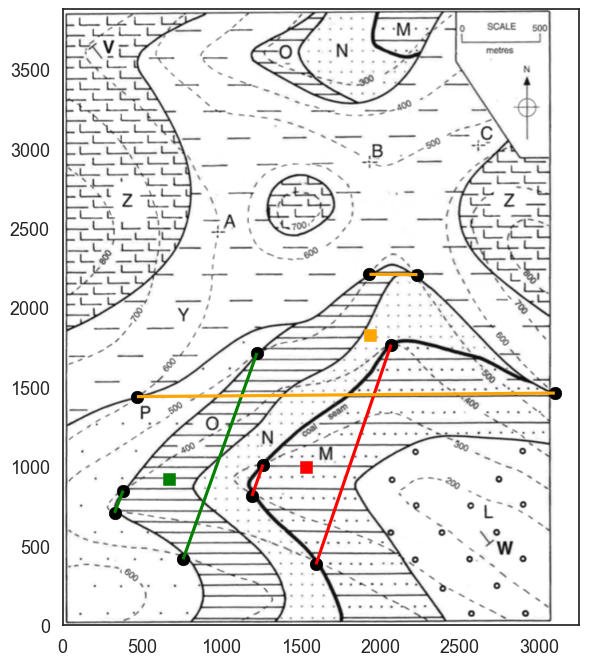

In [17]:
# Plot all this information on the map, squares are orientations
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(img, extent=[0, 3090, 0, 3880], cmap="gray")
# base N
gdf_N.plot(ax=ax, aspect="equal", color="black")
linestring_gdf_N.plot(ax=ax, aspect="equal", color="red")
orientations_N.plot(ax=ax, aspect="equal", color="red", marker="s")
# base P
gdf_P.plot(ax=ax, aspect="equal", color="black")
linestring_gdf_P.plot(ax=ax, aspect="equal", color="green")
orientations_P.plot(ax=ax, aspect="equal", color="green", marker="s")
# base Y
gdf_Y.plot(ax=ax, aspect="equal", color="black")
linestring_gdf_Y.plot(ax=ax, aspect="equal", color="orange")
orientations_Y.plot(ax=ax, aspect="equal", color="orange", marker="s");

In [18]:
# Merge orientations
orientations = pd.concat([orientations_N, orientations_P,orientations_Y]).reset_index()
orientations.head()

,index,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,0,10.90,288.87,350.00,POINT (1529.82800 995.14000),1.00,1529.83,995.14,N
1,0,11.28,289.72,450.00,POINT (672.57700 922.41375),1.00,672.58,922.41,P
2,0,7.56,359.52,550.00,POINT (1933.91100 1831.15300),1.00,1933.91,1831.15,Y


## 3. Construction of the model in GemPy

In [19]:
# Create a geomodel object called model3
geo_model = gp.create_model("model3")

In [20]:
# Define model extent, resolution, surface points, and orientations
gp.init_data(geo_model, [0, 3090, 0, 3880, 0, 1200], [100, 100, 100],
             surface_points_df=contacts_with_Z,
             orientations_df=orientations, default_values=True);

Active grids: ['regular']


In [21]:
# Check default series. We need to create 2 different series 
# for the units below and above the unconformity
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,P,Default series,1,#015482,1
1,O,Default series,2,#9f0052,2
2,N,Default series,3,#ffbe00,3
3,M,Default series,4,#728f02,4
4,Z,Default series,5,#443988,5
5,Y,Default series,6,#ff3f20,6


In [22]:
# The base of the lowermost unit L does not outcrop in the map
# This unit is our "basement", we add it manually
geo_model.add_surfaces("L")

# The units are divided into 2 series
# Strata1 = units above the unconformity
# Strata2 = units below the unconformity
gp.map_stack_to_surfaces(geo_model, {"Strata1": ("Z", "Y"), "Strata2": ("P", "O", "N", "M","L"),},
                         remove_unused_series=True)

,surface,series,order_surfaces,color,id
4,Z,Strata1,1,#443988,1
5,Y,Strata1,2,#ff3f20,2
0,P,Strata2,1,#015482,3
1,O,Strata2,2,#9f0052,4
2,N,Strata2,3,#ffbe00,5
3,M,Strata2,4,#728f02,6
6,L,Strata2,5,#5DA629,7


In [23]:
# Check that the data are correct
gg.utils.show_number_of_data_points(geo_model=geo_model)

,surface,series,order_surfaces,isBasement,isFault,isActive,hasData,color,vertices,edges,sfai,id,No. of Interfaces,No. of Orientations
4,Z,Strata1,1,False,False,True,True,#443988,NaN,NaN,NaN,1,6,0
5,Y,Strata1,2,False,False,True,True,#ff3f20,NaN,NaN,NaN,2,9,1
0,P,Strata2,1,False,False,True,True,#015482,NaN,NaN,NaN,3,3,1
1,O,Strata2,2,False,False,True,True,#9f0052,NaN,NaN,NaN,4,4,0
2,N,Strata2,3,False,False,True,True,#ffbe00,NaN,NaN,NaN,5,5,1
3,M,Strata2,4,False,False,True,True,#728f02,NaN,NaN,NaN,6,5,0
6,L,Strata2,5,True,False,True,True,#5DA629,NaN,NaN,NaN,7,0,0


In [24]:
# Set the topography of the model
geo_model.set_topography(source="gdal",filepath="dem_map3.tif");

Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']


In [25]:
# Plot the points on the contacts and topography in 3D 
# This will open a PyVista window. This may take some time, please wait
gp.plot_3d(geo_model, plotter_type="background",show_topography=True);

In [26]:
# Now we have enough data to interpolate. This may take some time, please wait
gp.set_interpolator(geo_model, compile_theano=True, 
                    theano_optimizer="fast_compile");

Setting kriging parameters to their default values.
Compiling aesara function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                    values
range             5103.19
$C_o$           620059.52
drift equations    [3, 3]


In [27]:
# Compute the geological model. This may take some time, please wait
gp.compute_model(geo_model);

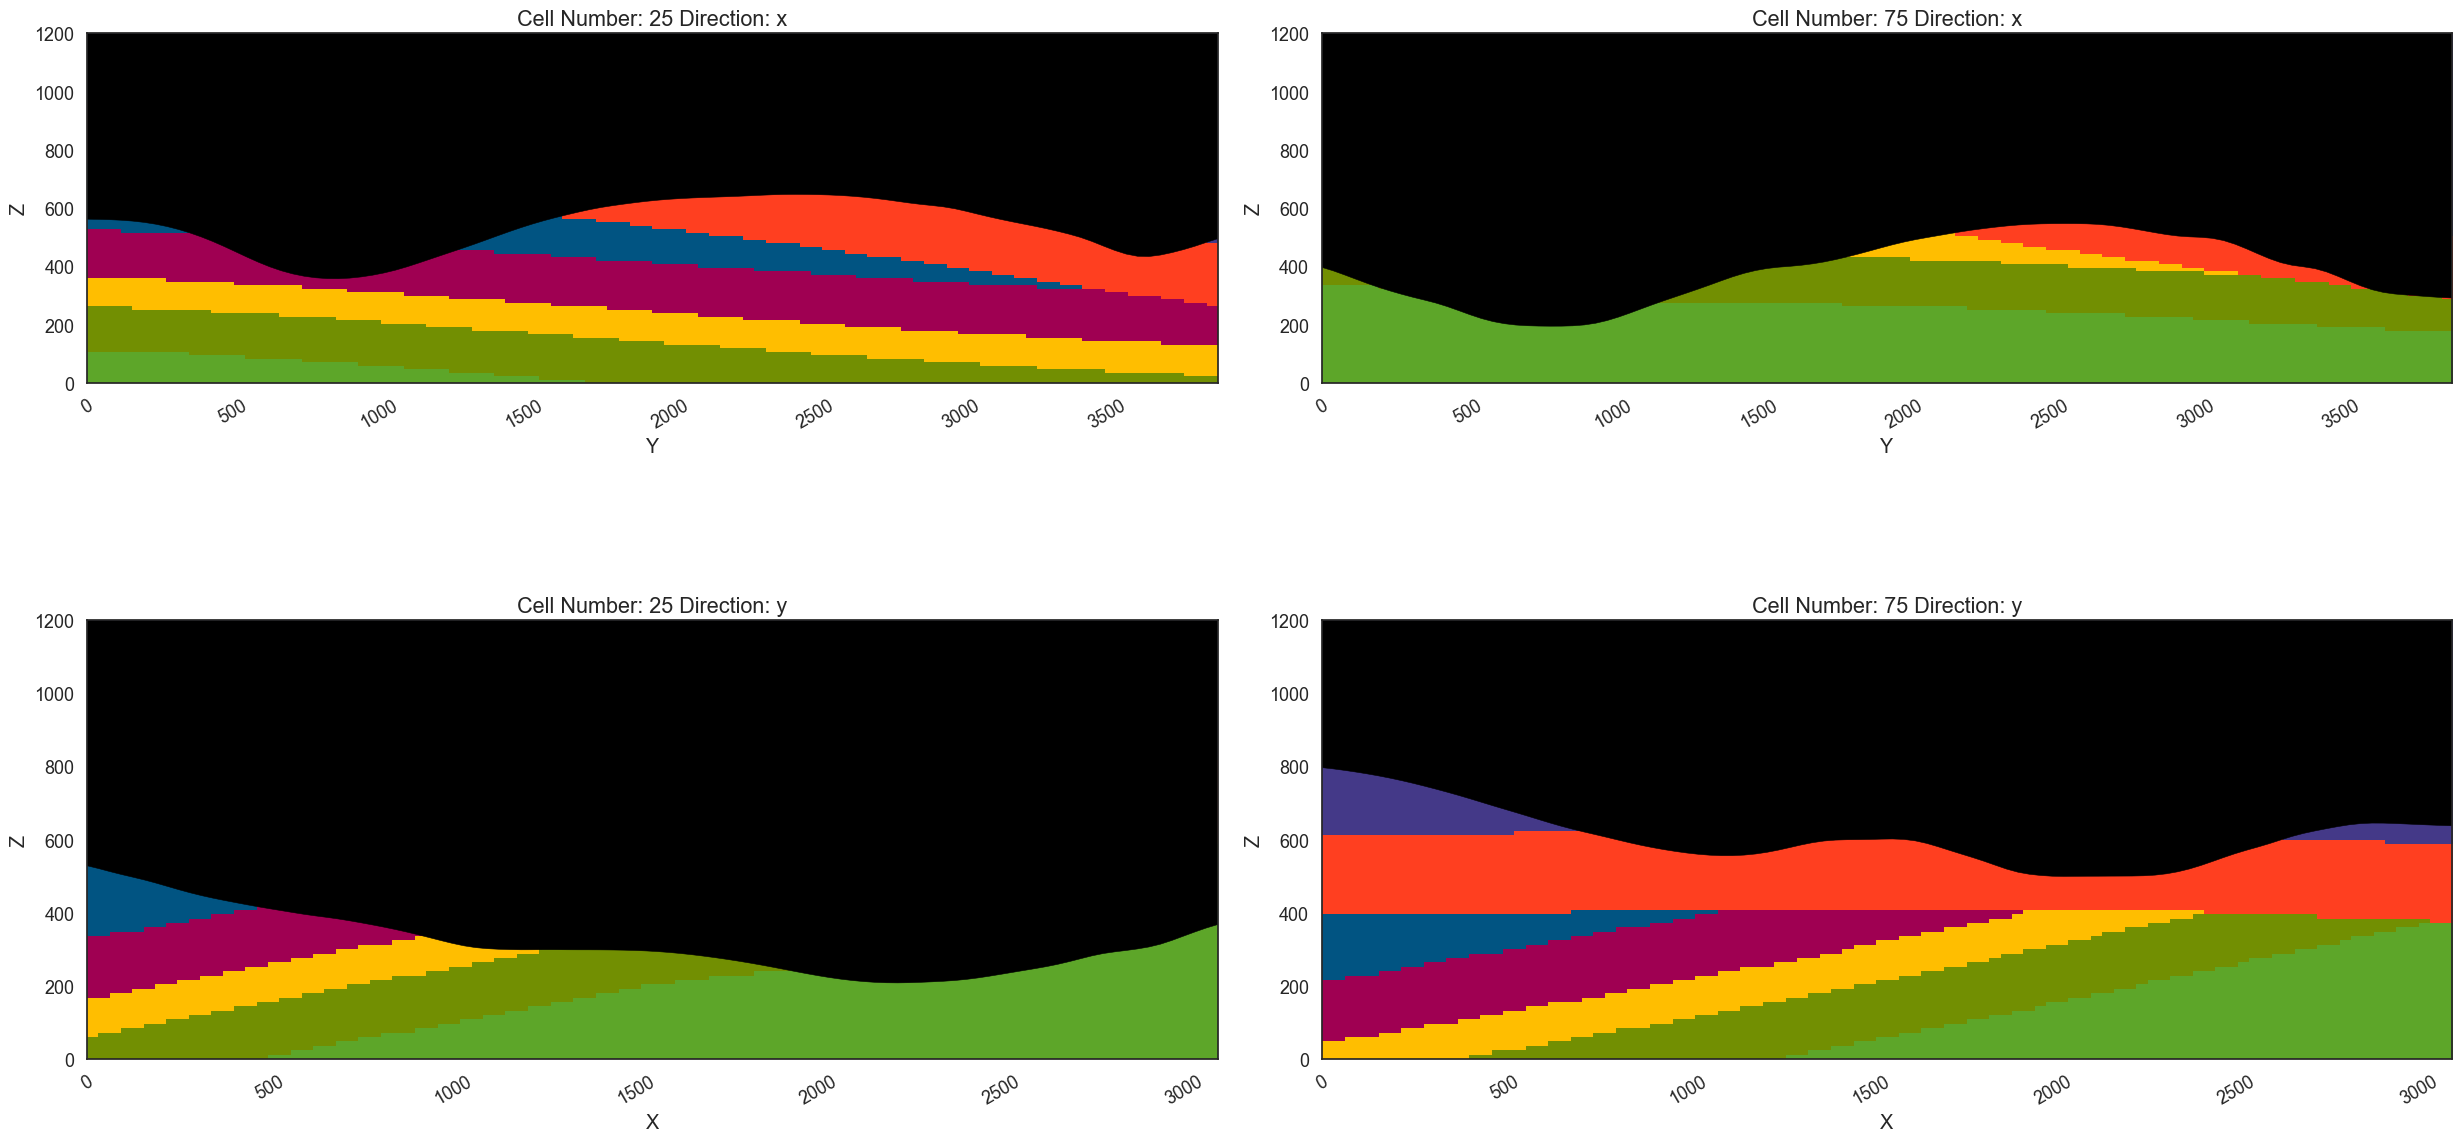

In [28]:
# Plot north-south and east-west sections without vertical exaggeration
gp.plot_2d(geo_model, direction=["x", "x", "y", "y"], cell_number=[25, 75, 25, 75], 
           show_data=False,show_boundaries=False, show_topography=True, show=False);

In [29]:
# Plot the geomodel in 3D, this will open a PyVista window. This may take some time, please wait
gp.plot_3d(geo_model, plotter_type="background", show_topography=True, show_lith=False);

Units Z and Y (ids 1 and 2) lie unconformably over units P to L (ids 3 to 7).